# Growth Deployment Calculations
We will think of the need for reactors in terms of their power capacity. When a LWR is retired, it will be replaced by an equivalent capacity of the advanced reactor models considered in the work.

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib
from collections import defaultdict
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../plotting.mplstyle')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
sys.path.insert(0,'../../../scripts')

In [3]:
import reactor_deployment as dep
import scenario_definitions as sd

## First, pull in the LWR data

In [4]:
# read in the LWR deployment data so we can establish a baseline.
lwr_df = pd.read_csv('lwr_info.csv')

# Remove the 'Unnamed: 0' column
lwr_df = lwr_df.drop('Unnamed: 0', axis=1)

In [5]:
# create the simulation retirement year (either the actual retirement or 80
# years after the startup year)
lwr_df['retirement_year'] = lwr_df['Actual retirement (year)'].fillna(
    lwr_df['Startup date (year) b'] + 80)

In [6]:
lwr_df

,Reactor name,State,Reactor type,Reactor vendora,Core size (number of assemblies),Startup date (year) b,License expiration (year),Actual retirement (year),power_cap,retirement_year
0,Arkansas Nuclear One 1,AR,PWR,B&W,177,1974,2034,NaN,836.0,2054.0
1,Arkansas Nuclear One 2,AR,PWR,CE,177,1978,2038,NaN,988.0,2058.0
2,Beaver Valley 1,PA,PWR,WE,157,1976,2036,NaN,908.0,2056.0
3,Beaver Valley 2,PA,PWR,WE,157,1987,2047,NaN,905.0,2067.0
4,Big Rock Point,MI,BWR,GE,84,1964,NaN,1997.0,67.0,1997.0
...,...,...,...,...,...,...,...,...,...,...
116,Yankee Rowe,MA,PWR,WE,76,1960,NaN,1991.0,167.0,1991.0
117,Zion 1,IL,PWR,WE,193,1973,NaN,1997.0,1040.0,1997.0
118,Zion 2,IL,PWR,WE,193,1973,NaN,1996.0,1040.0,1996.0
119,Vogtle 3,GA,PWR,WE,193,2023,2062,NaN,1117.0,2103.0


In [7]:
capacity_change = {year: 0 for year in range(sd.sim_start_yr, sd.sim_end_yr)}

# calculate the decommissioned capacity for each retirement year
for year, power in zip(lwr_df['retirement_year'], lwr_df['power_cap']):
    capacity_change[int(year)] -= power * sd.lwr_capacity_factor

# calculate the commissioned LWR capacity for each startup year
for year, power in zip(lwr_df['Startup date (year) b'], lwr_df['power_cap']):
    capacity_change[int(year)] += power * sd.lwr_capacity_factor

/var/folders/l6/x6vjc3312mq3ktq62t12b35r0000gn/T/ipykernel_63046/3600157219.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


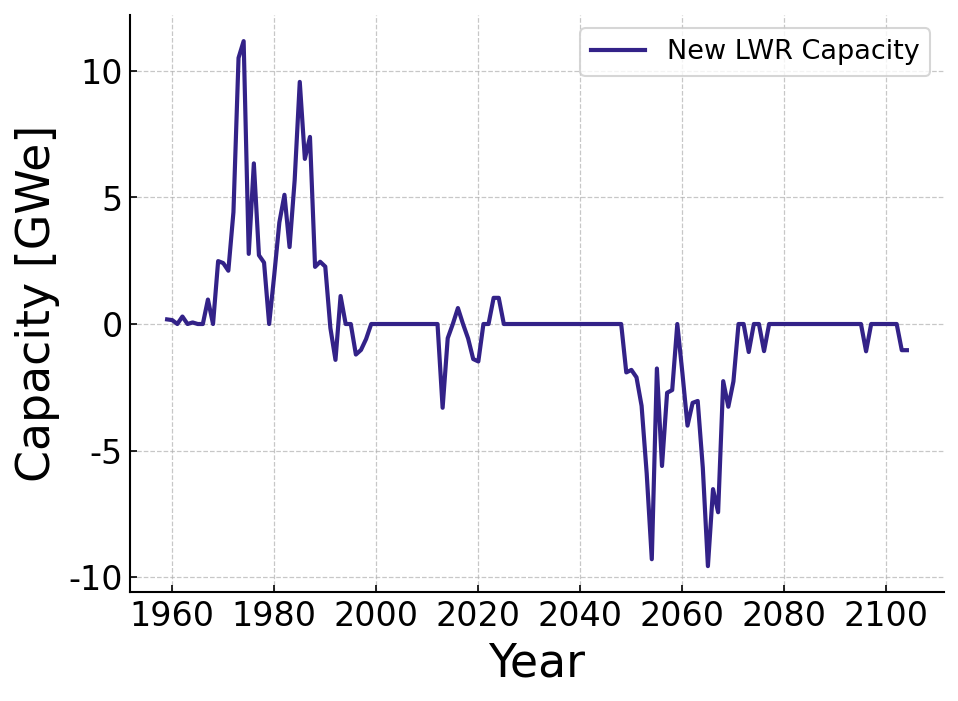

In [8]:
# Convert to a pandas DataFrame and plot.
capacity_change_df = pd.DataFrame(capacity_change.values(), index=capacity_change.keys(), columns=['new_LWR_Capacity'])
capacity_change_df.plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('New LWR Capacity')

In [9]:
# create a total lwr capacity column
capacity_change_df['Total LWR Capacity'] = capacity_change_df['new_LWR_Capacity'].cumsum()

/var/folders/l6/x6vjc3312mq3ktq62t12b35r0000gn/T/ipykernel_63046/722816693.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


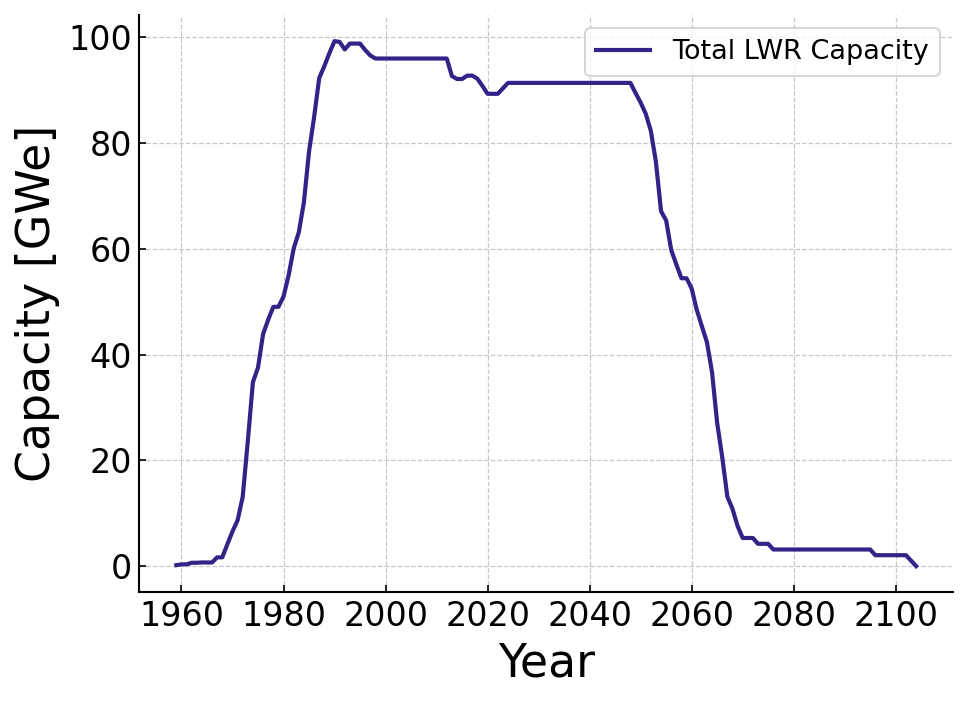

In [10]:
capacity_change_df[["Total LWR Capacity"]].plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('Total LWR Capacity')

## Capacity Expansion Calculations
In this section, I will perform the calculations required to do the energy demand increase. We will use the capacity from the transition_year variable in `scenario_definitions.py`

In [11]:
base_capacity = capacity_change_df.loc[sd.transition_year, 'Total LWR Capacity'] # in MWe

print(f"Total LWR capacity in {sd.transition_year}: {base_capacity} MWe")

Total LWR capacity in 2029: 91345.6 MWe


In [12]:
def capacity_increase(df, base_col, rate, start_year=sd.transition_year, end_year=sd.sim_end_yr):
    """
    This function takes in an increase rate, and creates a new column in the dataframe populated with the increased capacity.

    Parameters
    ----------
    df : pandas DataFrame
        The dataframe to add the new column to.
    base_col : str
        The name of the column to use as the base capacity.
        This column should contain the net capacity.
    rate : float
        The percentage of change in capacity year-to-year
        (e.g. 1.01 for a 1% increase).
    start_year : int
        The year to start the increase.
    end_year : int
        The year to end the increase.

    Returns
    -------
    df : pandas DataFrame
        The dataframe with the new column added.
    """
    for year in range(start_year, end_year):
        df.loc[year, f"{base_col} Inc {rate}"] = \
            df.loc[start_year, base_col] * (rate)**(year - start_year)

    for year in range(df.index[0], start_year):
        df.loc[year, f"{base_col} Inc {rate}"] = df.loc[year, base_col]
    return df

In [13]:
test_df = capacity_change_df.copy()
capacity_increase(test_df, 'Total LWR Capacity', 1.01)

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1.01
1959,182.225,1.822250e+02,182.225000
1960,154.475,3.367000e+02,336.700000
1961,0.000,3.367000e+02,336.700000
1962,296.000,6.327000e+02,632.700000
1963,0.000,6.327000e+02,632.700000
...,...,...,...
2100,0.000,2.066450e+03,185142.093984
2101,0.000,2.066450e+03,186993.514923
2102,0.000,2.066450e+03,188863.450073
2103,-1033.225,1.033225e+03,190752.084573


/var/folders/l6/x6vjc3312mq3ktq62t12b35r0000gn/T/ipykernel_63046/630761047.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


Text(0, 0.5, 'Capacity [GWe]')

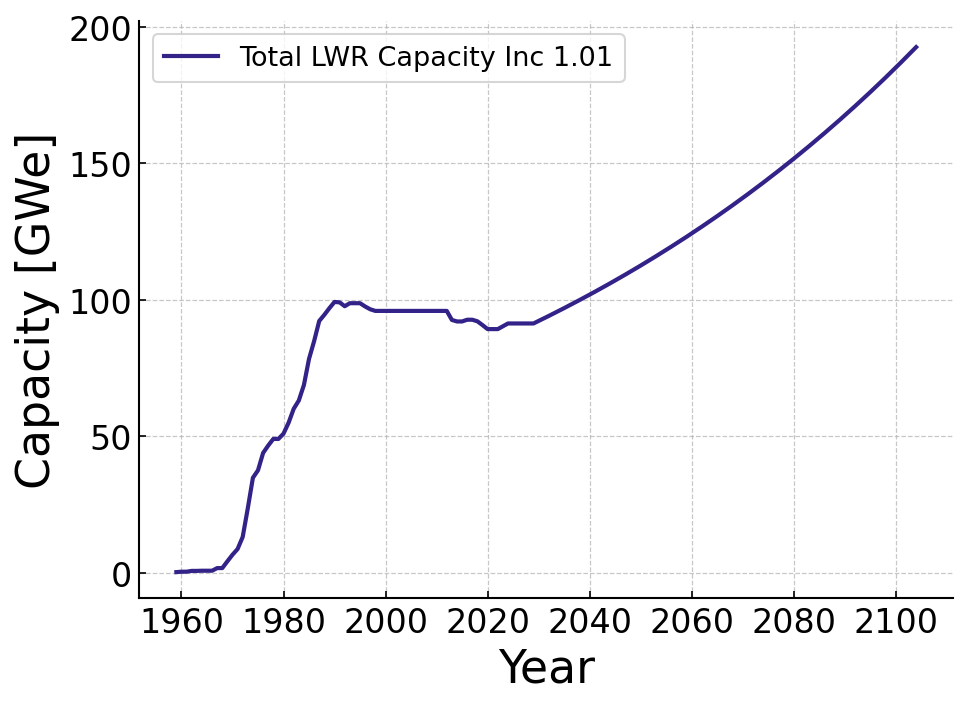

In [14]:
test_df[['Total LWR Capacity Inc 1.01']].plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

# No Growth Scenarios
Growth Rate: 1

In this section, we will use the functions in `reactor_deployment.py` to deploy the advanced reactors to meet demand.

In [15]:
no_growth_cap_df = capacity_change_df.copy()
capacity_increase(no_growth_cap_df, 'Total LWR Capacity', 1)

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1
1959,182.225,1.822250e+02,182.225
1960,154.475,3.367000e+02,336.700
1961,0.000,3.367000e+02,336.700
1962,296.000,6.327000e+02,632.700
1963,0.000,6.327000e+02,632.700
...,...,...,...
2100,0.000,2.066450e+03,91345.600
2101,0.000,2.066450e+03,91345.600
2102,0.000,2.066450e+03,91345.600
2103,-1033.225,1.033225e+03,91345.600


/var/folders/l6/x6vjc3312mq3ktq62t12b35r0000gn/T/ipykernel_63046/2516189634.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


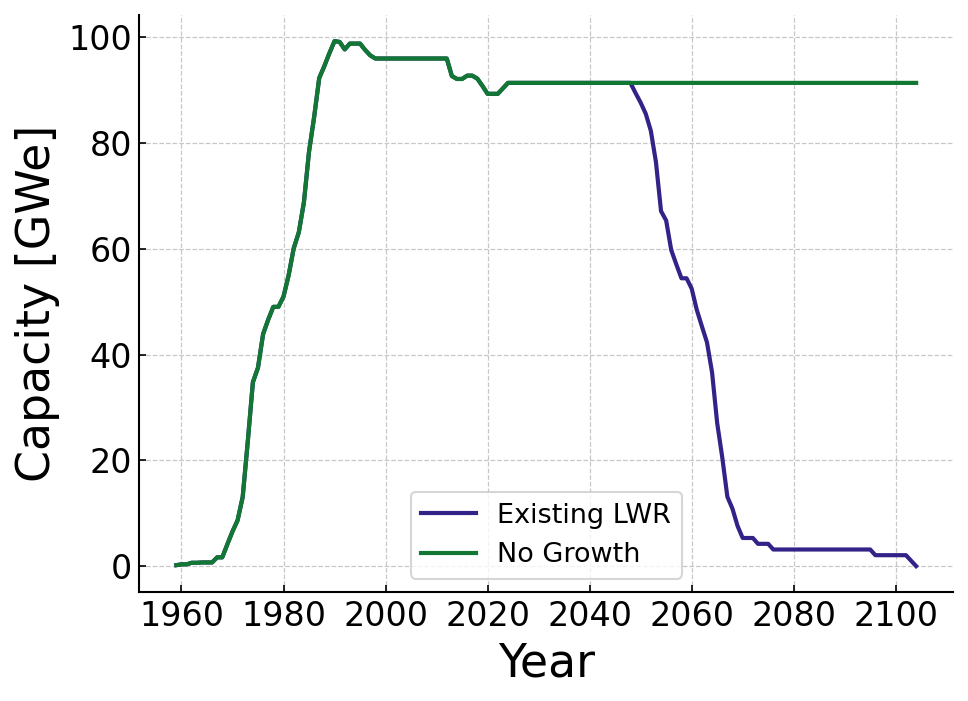

In [16]:
no_growth_cap_df[['Total LWR Capacity','Total LWR Capacity Inc 1']].plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('No Growth')

# Greedy Deployment

In [17]:
greedy_no_growth_cap_df = no_growth_cap_df.copy()

In [18]:
greedy_no_growth_cap_df

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1
1959,182.225,1.822250e+02,182.225
1960,154.475,3.367000e+02,336.700
1961,0.000,3.367000e+02,336.700
1962,296.000,6.327000e+02,632.700
1963,0.000,6.327000e+02,632.700
...,...,...,...
2100,0.000,2.066450e+03,91345.600
2101,0.000,2.066450e+03,91345.600
2102,0.000,2.066450e+03,91345.600
2103,-1033.225,1.033225e+03,91345.600


In [19]:
greedy_no_growth_cap_df = greedy_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

In [20]:
dep.greedy_deployment(greedy_no_growth_cap_df, "Total LWR Capacity Inc 1", sd.ad_reactors)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,num_Xe100,num_MMR,Xe100Decom,MMRDecom,total_cap,new_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap
0,1959,182.225,1.822250e+02,182.225,2,4,0,0,180,180,160,160,20,20
1,1960,154.475,3.367000e+02,336.700,4,3,0,0,335,335,320,320,15,15
2,1961,0.000,3.367000e+02,336.700,4,3,0,0,335,335,320,320,15,15
3,1962,296.000,6.327000e+02,632.700,7,14,0,0,630,630,560,560,70,70
4,1963,0.000,6.327000e+02,632.700,7,14,0,0,630,630,560,560,70,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2100,0.000,2.066450e+03,91345.600,2918,89,1777,76,233885,91345,91280,233440,65,445
142,2101,0.000,2.066450e+03,91345.600,2969,76,1828,63,237900,91345,91280,237520,65,380
143,2102,0.000,2.066450e+03,91345.600,3032,99,1891,86,243055,91345,91280,242560,65,495
144,2103,-1033.225,1.033225e+03,91345.600,3070,98,1929,85,246090,91345,91280,245600,65,490


Text(0, 0.5, 'Number of Reactors [#]')

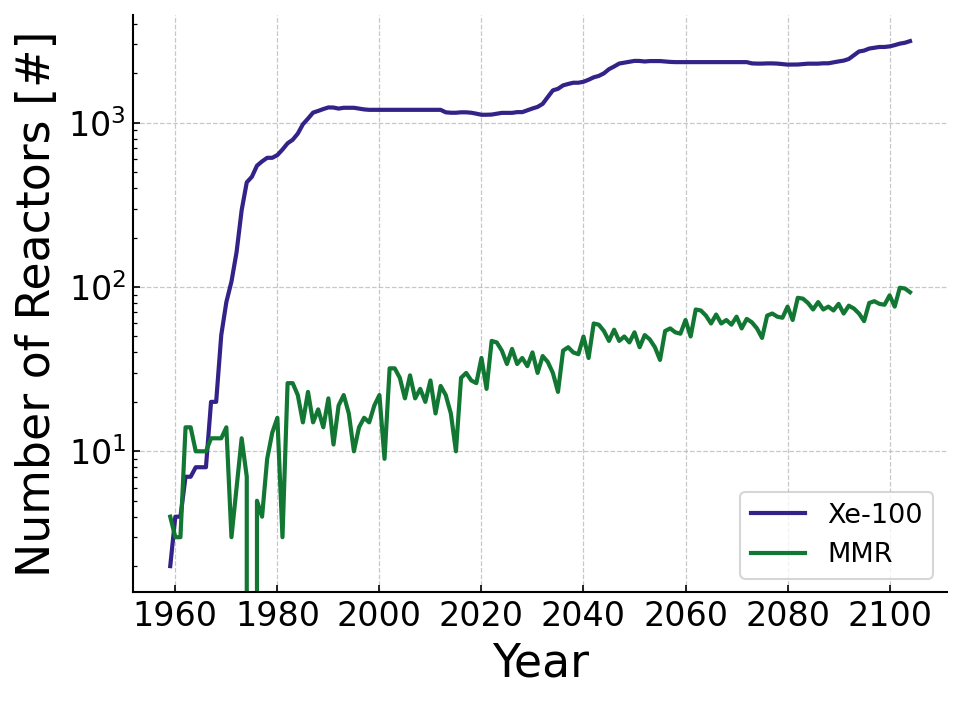

In [21]:
e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

greedy_no_growth_cap_df[h].plot(x='Year', logy=True, style=hs)


plt.xlabel('Year')

legend = plt.legend()
# g
# legend.get_texts()[0].set_text('Existing LWR')
# legend.get_texts()[1].set_text('No Growth')
# legend.get_texts()[2].set_text('New Cap + AR')
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
legend.get_texts()[0].set_text('Xe-100')
legend.get_texts()[1].set_text('MMR')
plt.ylabel('Number of Reactors [#]')

## Pre Determined Distribution
This section I will skip at the moment as I have not put enough thought into scenarios that would be of interested based on what companies are saying. At present, I think staggering the initial deployment of each technology is the most i can say about the distribution of any specific reactor technology based on the deadlines they are trying to meet.

## Rough Random Deployment
I will only use the rough case as I am not confident the true random case will converge. 

Tolerance will be 5, and the seed will be set for now with the `True` argument.

In [22]:
rrd_no_growth_cap_df = no_growth_cap_df.copy()

In [23]:
rrd_no_growth_cap_df

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1
1959,182.225,1.822250e+02,182.225
1960,154.475,3.367000e+02,336.700
1961,0.000,3.367000e+02,336.700
1962,296.000,6.327000e+02,632.700
1963,0.000,6.327000e+02,632.700
...,...,...,...
2100,0.000,2.066450e+03,91345.600
2101,0.000,2.066450e+03,91345.600
2102,0.000,2.066450e+03,91345.600
2103,-1033.225,1.033225e+03,91345.600


In [24]:
rrd_no_growth_cap_df = rrd_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

In [25]:
dep.rand_deployment(rrd_no_growth_cap_df, "Total LWR Capacity Inc 1", sd.ad_reactors, set_seed=True, rough=True, tolerance=5)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,num_Xe100,num_MMR,Xe100Decom,MMRDecom,total_cap,new_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap
0,1959,182.225,1.822250e+02,182.225,2,0,0,0,160,160,160,160,0,0
1,1960,154.475,3.367000e+02,336.700,4,1,0,0,325,325,320,320,5,5
2,1961,0.000,3.367000e+02,336.700,4,1,0,0,325,325,320,320,5,5
3,1962,296.000,6.327000e+02,632.700,7,5,0,0,585,585,560,560,25,25
4,1963,0.000,6.327000e+02,632.700,7,5,0,0,585,585,560,560,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2100,0.000,2.066450e+03,91345.600,2736,7496,1666,6356,256360,91300,85600,218880,5700,37480
142,2101,0.000,2.066450e+03,91345.600,2784,7545,1714,6405,260445,91300,85600,222720,5700,37725
143,2102,0.000,2.066450e+03,91345.600,2844,7604,1774,6464,265540,91300,85600,227520,5700,38020
144,2103,-1033.225,1.033225e+03,91345.600,2880,7668,1810,6528,268740,91300,85600,230400,5700,38340


Text(0, 0.5, 'Capacity [GWe]')

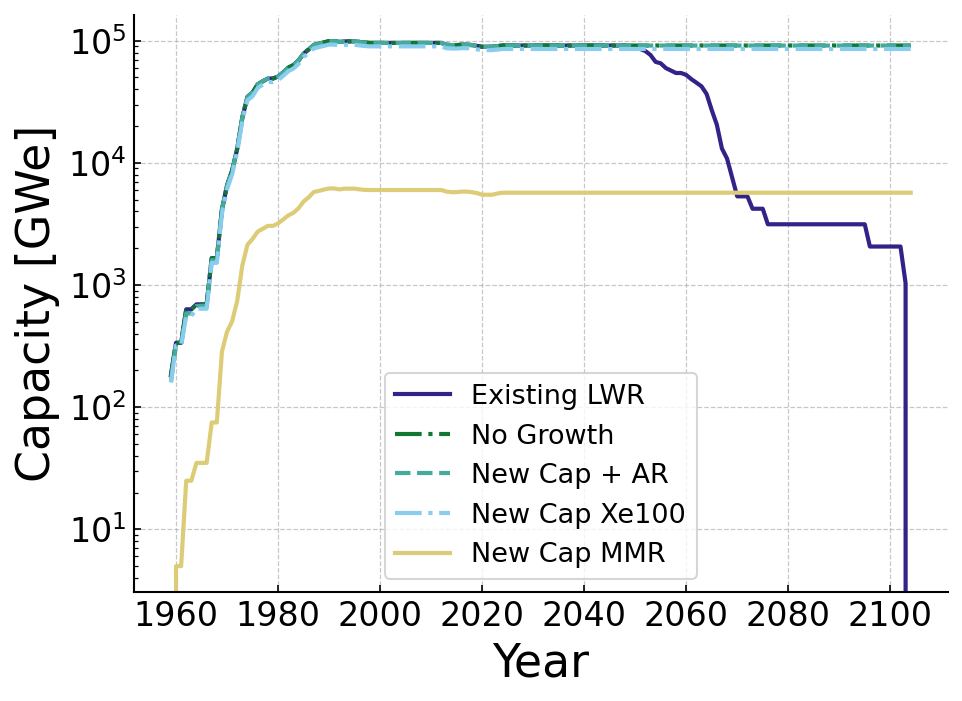

In [28]:
g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

rrd_no_growth_cap_df[g].plot(x='Year', logy=True, style=gs)

plt.xlabel('Year')

legend = plt.legend()
# g
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('No Growth')
legend.get_texts()[2].set_text('New Cap + AR')
legend.get_texts()[3].set_text('New Cap Xe100')
legend.get_texts()[4].set_text('New Cap MMR')
# Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
# legend.get_texts()[0].set_text('Xe-100')
# legend.get_texts()[1].set_text('MMR')
# plt.ylabel('Number of Reactors [#]')

# graveyard 

In [ ]:
desired_cap_increase = [1.01, 1.05, 1.10, 1.15, 2.00, 3.00]

# %%
# create the dataframe for the expansion of capacity
cap_expand_df = pd.DataFrame(data=cap_need_df, columns=['Year'])

# pull the indices for the start and end of capacity expansion
exp_start_ind = cap_expand_df.index[cap_expand_df['Year']==transition_year].to_list()[0]
exp_end_ind = len(cap_expand_df['Year'])

# iterate through the years of expansion
for cap_inc in desired_cap_increase:
    years_of_exp = 0
    cap_expand_df[f'ExpandedCapacity{cap_inc}'] = 0
    for year in range(exp_start_ind, exp_end_ind):
        # get the additional capacity for each year
        cap_expand_df.loc[year, f'ExpandedCapacity{cap_inc}'] = base_capacity * (cap_inc ** years_of_exp) - base_capacity * (cap_inc ** (years_of_exp - 1))
        years_of_exp += 1

# %%
cap_expand_df[['Year','ExpandedCapacity1.01','ExpandedCapacity1.05','ExpandedCapacity1.1','ExpandedCapacity1.15', 'ExpandedCapacity2.0', 'ExpandedCapacity3.0']].plot(x='Year', logy=True)

plt.xlim(2025,2096)
plt.ylabel('Expanded Capacity [MWe]')
plt.xlabel('Year [#]')

# %% [markdown]
# ### Deploy individual reactor models to meet capacity

# %%
for cap_inc in desired_cap_increase:
    for reactor in ad_reactors.keys():
        cap_expand_df[f'Expand{reactor}{cap_inc}'] = cap_expand_df.loc[cap_expand_df['Year']>transition_year, f'ExpandedCapacity{cap_inc}'] * ad_reactors[reactor][1]/ad_reactors[reactor][0]

        # set the number of reactors before the transition year to zero
        cap_expand_df.loc[cap_expand_df['Year']<=transition_year, f'Expand{reactor}{cap_inc}'] = 0

        # make the number of reactors an int
        cap_expand_df[f'Expand{reactor}{cap_inc}'] = cap_expand_df[f'Expand{reactor}{cap_inc}'].apply(lambda x: math.ceil(x))

# %%
# now we are going to note when reactors are decommissioned
for cap_inc in desired_cap_increase:
    for reactor in ad_reactors.keys():
        # create a decommissioning column
        cap_expand_df[f'Expand{reactor}{cap_inc}Decom'] = 0
        for year in range(len(cap_expand_df['Year'])):
            decom_year = year + ad_reactors[reactor][2]
            if decom_year >= len(cap_expand_df['Year']):
                pass
            else:
                # tracks the number of decommissioned reactors
                try:
                    cap_expand_df.loc[decom_year, f'Expand{reactor}{cap_inc}Decom'] += cap_expand_df.loc[year, f'Expand{reactor}{cap_inc}']
                except OverflowError:
                    cap_expand_df[f'Expand{reactor}{cap_inc}Decom'] = cap_expand_df[f'Expand{reactor}{cap_inc}Decom'].astype(np.int64)

                # construct new reactors to replace the decommissioned ones
                cap_expand_df.loc[decom_year, f'Expand{reactor}{cap_inc}'] += cap_expand_df.loc[year, f'Expand{reactor}{cap_inc}']

# %%
# create total reactor columns for each of the advanced reactors
for cap_inc in desired_cap_increase:
    for reactor in ad_reactors.keys():
        cap_expand_df[f'TotalExpand{reactor}{cap_inc}'] = cap_expand_df[f'Expand{reactor}{cap_inc}'].cumsum() - cap_expand_df[f'Expand{reactor}{cap_inc}Decom'].cumsum()
